In [373]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.optimizers import RMSprop, adam
from keras.utils.data_utils import get_file
from keras.callbacks import History, ModelCheckpoint
import numpy as np
import pandas as pd
import random
import sys
import string
import matplotlib.pyplot as plt
%matplotlib inline

# Define number of inputs/outputs to handle
input_size = 2
output_size =2

# Load the train data
#path = "???.csv"
#df = pd.read_csv(path)

df = np.zeros((500,16,1),dtype=int)
for i in range(500):
    if i%3 == 0:       
        df[i,:,:] = 1    


print('Train total outputs:', output_size)

# Pre-process the data (normalize)

# cut the input in semi-redundant sequences of maxlen characters
maxlen = 60
step_days = 1
max_sequences = 10**5
days_sequence = np.empty((max_sequences,maxlen,input_size),dtype=int)
next_day = np.empty((max_sequences,output_size),dtype=int)

j=0
for woman_i in range(0,df.shape[2]):
    for day_i in range(0, df.shape[0] - maxlen, step_days):
        days_sequence[j] = df[day_i: day_i + maxlen,:input_size,woman_i]
        next_day[j] = df[day_i + maxlen,:output_size,woman_i]
        j += 1
days_sequence = days_sequence[:j,:,:]
next_day = next_day[:j,:]
        
print('Train nb sequences:', len(days_sequence))

X_train=days_sequence#.reshape(days_sequence.shape[0],days_sequence.shape[1],1,days_sequence.shape[2])
y_train=next_day

X_test=days_sequence[:50,:,:]#.reshape(-1,days_sequence.shape[1],1,days_sequence.shape[2])
y_test=next_day[:50,:]

"""from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)"""

Train total outputs: 2
Train nb sequences: 440


'from keras.utils.np_utils import to_categorical\ny_train = to_categorical(y_train)\ny_test = to_categorical(y_test)'

In [374]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(440, 60, 2)
(440, 2)
(50, 60, 2)
(50, 2)


In [375]:
def plot_logs(history):
    """
    Plot the accuracy and loss for 
        training and test sets
    """
    evaluation_cost = history.history['val_loss']
    evaluation_accuracy = history.history['val_acc']
    training_cost = history.history['loss']
    training_accuracy = history.history['acc']
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_figwidth(10)
    ax1.plot(evaluation_cost,label= 'test')
    ax1.plot(training_cost, label='train')
    ax1.set_title('Cost')
    ax1.legend()
    ax2.plot(evaluation_accuracy, label='test')
    ax2.plot(training_accuracy, label='train')
    ax2.set_title('Accuracy')
    ax2.legend(loc='lower right')


def sample(preds, temperature=1.0):
    """
    Generate the next sequence
    Low temperature means very conservative (picks more probable most of the time)
    High temperature means very adventurous (picks less probable more frequently)
    """
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_prediction(history,days=28, maxlen=60, input_size=16, output_size=16, diversity=1):
    """
    Generates as many days of prediction as requested
    Considers maxlen days of past history (must be aligned with model)
    """
    generated = np.zeros((days,output_size))
    if history.shape[1]>60:
        x = history[:,-61:-1,:input_size]
    else:
        x = history[:,:,:input_size]
    #print(x.shape)
    for i in range(days):
        #print("Day %d" % i)
        preds = model.predict(x, verbose=0)[0]
        #print(preds)
        #next_symptoms = sample(preds, diversity)
        next_symptoms = preds
        #print(next_symptoms)

        generated[i,:] = next_symptoms
        x[:,:maxlen-1,:] = x[:,1:,:]
        x[:,maxlen-1,:] = next_symptoms

    return generated

Build model...
Epoch 00000: val_acc improved from -inf to 0.50000, saving model to lstm_1_layer.hdf5
Epoch 00001: val_acc did not improve
Epoch 00002: val_acc did not improve
Epoch 00003: val_acc did not improve
Epoch 00004: val_acc did not improve
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc did not improve
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc did not improve
Epoch 00010: val_acc did not improve
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc did not improve
Epoch 00013: val_acc did not improve
Epoch 00014: val_acc did not improve
Epoch 00015: val_acc did not improve
Epoch 00016: val_acc did not improve
Epoch 00017: val_acc did not improve
Epoch 00018: val_acc did not improve
Epoch 00019: val_acc did not improve
Test score: 0.693147382736
Test accuracy: 0.500000021458


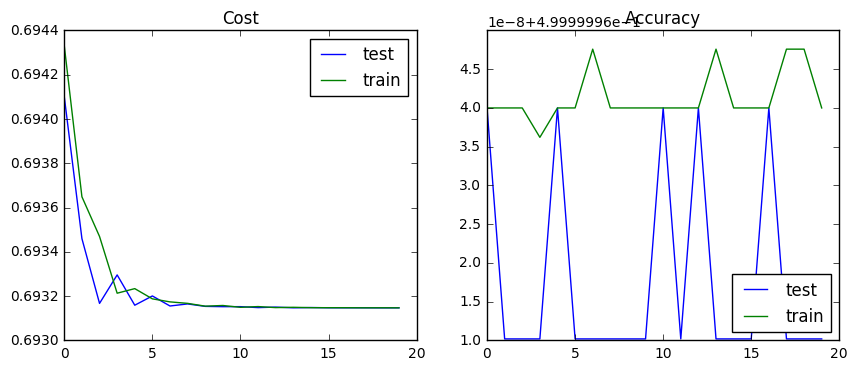

In [376]:
# Model params
batch_size = 128
nb_epoch = 20
np.random.seed(131078)

# build the model
print('Build model...')


filepath="lstm_1_layer.hdf5"
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, input_size)))
model.add(Dense(output_size))
model.add(Activation('softmax'))

"""
filepath="lstm_2_layers.hdf5"
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, input_size), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(output_size))
model.add(Activation('softmax'))
"""

optimizer = adam()
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])

# Define callback to save model
save_snapshots = ModelCheckpoint(filepath,
                                 monitor='val_acc',
                                 save_best_only=True,
                                 save_weights_only=True,
                                 mode='max',
                                 verbose=1)
callbacks_list = [save_snapshots]

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0)          

score = model.evaluate(X_test, y_test, verbose=2)
print('Test score:', score[0])
print('Test accuracy:', score[1])  

plot_logs(history)          


In [377]:
res = generate_prediction(X_test[0,:,:].reshape(1,60,-1),input_size=input_size,output_size=output_size)
res.shape

(28, 2)

In [362]:
res[:,:output_size]

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]])

In [335]:
y_train[1,:2]

array([0])

In [336]:
X_train[1,:,:2]

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1]])